In [1]:
# Imports

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import geopandas

In [2]:
# Copy all messages received from the inreach in here

TEXT_RECIEVED = """
12,24,36,48
2022-11-17 12:00:00
24.0,36.0,-72.0,-58.0
2.0,2.0
1
>+g9&g8>>'6>"'ä7>+CP¤oäP¤t+Q8>-x>+æO&gA8>'8>+gæ>,+g8&gi8
0
1
>'eO>+8?>+æP7+A8¤g8>,+æ6+gA7=gA8+g6_¤oe#>/æg¤+gP¤gA8>,)7+gg8>"A>+ke8>+æ8g8>¤pÑΔ+o@@AOQ54">>1o"kèØΣcgZΘ@@É8XÑΓ+fÑöΘgFñhH0
1
2
zΛ>:¤ÑøgjÑΣSØ5ΘbÇÑg8>¤o7ΦΞoC?ΘY8xM>:zXågjüèLaM+"'Sg8>¤g4>*gåüΘfØP&8¤xHÑ'èoæP0<@?c5@?
END
2
"""

# Indicate your location for visuslisation

OUR_LOCATION = (-62.93,20.8219)

In [3]:
# Decoder function

def decoder(x,shift):
    inreach_chars = """!"#$%\'()*+,-./:;<=>?_¡£¥¿&¤0123456789ABCDEFGHIJKLMNOPQRSTUVWXYZabcdefghijklmnopqrstuvwxyzÄÅÆÇÉÑØøÜßÖàäåæèéìñòöùüΔΦΓΛΩΠΨΣΘΞ"""
    extra_chars = {'@!':122,'@@':123,'@#':124,'@$':125,'@%':126,'@?':127}
    new_chars = inreach_chars[shift:] + inreach_chars[:shift]
    
    decoded = []
    counter = 0
    while(counter < len(x)):
        if x[counter] == '@':
            decoded.append("{0:07b}".format(extra_chars[x[counter:counter+2]]))
            counter = counter + 2
        else:
            decoded.append("{0:07b}".format(new_chars.index(x[counter])))
            counter = counter + 1
    
    decoded = ''.join(decoded)
    decoded = [decoded[i:i+4] for i in range(0, len(decoded), 4)]
    if len(decoded[-1]) < 4:
        del decoded[-1]
    decoded = [int(i,2) for i in decoded]
    mag = pd.Series(decoded[:int(len(decoded)/2)])
    dirs = pd.Series(decoded[int(len(decoded)/2):]).reset_index(drop=True)
    
    mag = mag*5
    v10 = np.sin(2*np.pi*dirs/16)*mag
    u10 = np.cos(2*np.pi*dirs/16)*mag
    
    idx = []
    for h in hours:
        for lat in np.arange(float(maxmin[0]),float(maxmin[1]) + float(interval[0]),float(interval[0])):
            for lon in np.arange(float(maxmin[2]),float(maxmin[3]) + float(interval[1]),float(interval[1])):
                idx.append({'hour':h,'lat':lat,'lon':lon})
    decoded = pd.DataFrame(idx)
    decoded['u10'] = u10
    decoded['v10'] = v10
    
    return decoded.set_index(['hour','lat','lon'])

In [4]:
# Extract variables and call decoder

lines = TEXT_RECIEVED.strip().split('\n')
hours = lines[0].split(',')
gribtime = lines[1]
maxmin = lines[2].split(',')
interval = lines[3].split(',')
shift = lines[4]

df = decoder(''.join(lines[5:-2][::3]), 1)

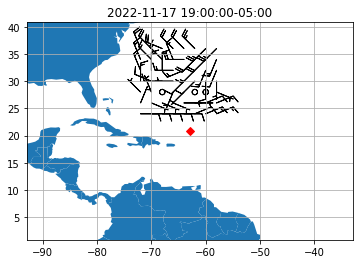

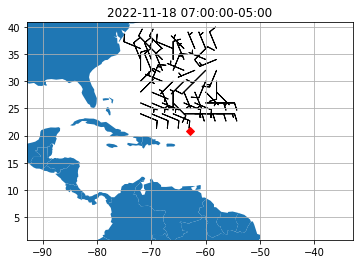

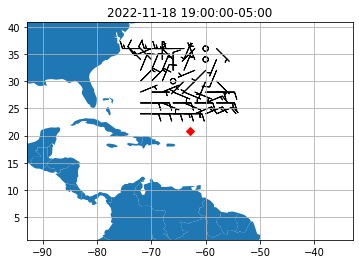

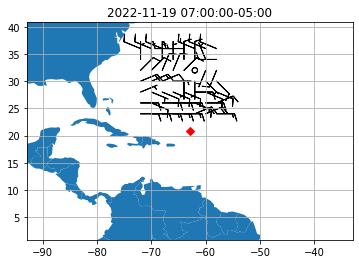

In [7]:
# Visualise encoded data
%matplotlib inline
#%matplotlib notebook # interactive version

world = geopandas.read_file(geopandas.datasets.get_path('naturalearth_lowres'))

for timepoint in df.index.get_level_values(0).unique():
    world.plot()
    g = df.loc[timepoint].reset_index()
    plt.plot(OUR_LOCATION[0], OUR_LOCATION[1], marker='D',c='red')
    plt.barbs(g['lon'], g['lat'], g['u10'], g['v10'], length=6)
    
    plt.title((pd.to_datetime(gribtime) + pd.Timedelta(hours=int(timepoint))).tz_localize('UTC').tz_convert('US/Eastern'))
    plt.xlim([OUR_LOCATION[0]-30,OUR_LOCATION[0]+30])
    plt.ylim([OUR_LOCATION[1]-20,OUR_LOCATION[1]+20])
    plt.grid(True)
    plt.show()